## Алгоритм, основанный на вейвлет-преобразовании сигнала

In [1]:
import numpy as np
from scikits.audiolab import Sndfile
from scipy import signal
import seaborn as sns
import os
from scikits.audiolab import wavread
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy.signal import wiener
import xgboost as xgb
from sklearn.model_selection  import GroupKFold
from biosppy.signals import ecg
from tqdm import tqdm
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from itertools import chain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import gensim
import os

## Чтение данных

In [2]:
def read_frame(directory, filename):
    data, sample_frequency, encoding = wavread(directory + "/" + filename)
    return np.array(data)

def get_frames(directory, files):
    frames = []
    for i in files:
        patient = i.split("_")[0]
        ecg_id = i[:-4]
        a = read_frame(directory, i)
        frames.append([a, patient, ecg_id])
    frames = np.array(frames)
    return np.swapaxes(frames, 0, 1)

def create_data_frame_from_wav(true_files_dir, false_files_dir):
    true_files = filter(lambda x: x.endswith(".wav"), os.listdir(true_files_dir))
    false_files = filter(lambda x: x.endswith(".wav"), os.listdir(false_files_dir))
    true_frames = get_frames(true_files_dir, true_files)
    false_frames = get_frames(false_files_dir, false_files)
    a = create_data_frame(true_frames, True)
    b = create_data_frame(false_frames, False)
    df = a.append(b).copy()
    del a
    del b
    df = shuffle(df, random_state=27)
    df = df.reset_index()
    df.drop("index", axis=1, inplace=True)
    df["SignalLen"] = df["S"].apply(lambda x: len(x))
    df = df[df["SignalLen"] != 0].copy()
    return df

def create_data_frame(data, ibs):
    df = pd.DataFrame({"S":data[0], "Patient": data[1], "ibs":ibs, "ECG_ID":data[2]})
    return df

df_train = create_data_frame_from_wav("wav/true", "wav/false")
df_test = create_data_frame_from_wav("wav_test/true", "wav_test/false")

ecg_ids = pd.read_csv("test_ids.csv", header=None)
df_test = df_test[df_test["ECG_ID"].isin(ecg_ids[0])]

In [3]:
import pywt as pw
from scipy import stats as ss

## Стандартизация сигнала

In [4]:
df_train["SS"] = df_train["S"].apply(lambda x: ss.zscore(x))
df_test["SS"] = df_test["S"].apply(lambda x: ss.zscore(x))

## Аппроксимирующие коэффициенты вейвлет-разложения

In [5]:
df_train["WSS"] = df_train["SS"].apply(lambda x: pw.dwt(x, 'db3')[0])
df_test["WSS"] = df_test["SS"].apply(lambda x: pw.dwt(x, 'db3')[0])

In [6]:
df_train.drop(["SS", "S"], axis=1, inplace=True)
df_test.drop(["SS", "S"], axis=1, inplace=True)

## Параметры для построения признакового пространства. 

In [7]:
WINDOW_SIZE = 100
STEP = 35
WORDS_NUMBER = 200#число кластеров

### Составление признакового пространства

In [8]:
def get_text(result, local_segments_numbers):
    texts = []
    ind = 0
    for i in local_segments_numbers: 
        texts.append(result[ind:ind+i].copy())
        ind += i
    return texts

In [9]:
def create_features(train_data, test_data):
    train_data = train_data.copy()
    test_data = test_data.copy()
    train_m = train_data["local_segments"].as_matrix()
    test_m = test_data["local_segments"].as_matrix()
    train_segments = np.array(list(chain.from_iterable(train_m)))
    test_segments = np.array(list(chain.from_iterable(test_m)))
    kmeans = MiniBatchKMeans(n_clusters=WORDS_NUMBER, random_state=0)
    train_result = kmeans.fit_predict(train_segments)
    print "train_ready"
    test_result = kmeans.predict(test_segments)
    print "test_ready"
    
    train_data["texts"] = pd.Series(get_text(train_result, train_data["local_segments_len"]))
    test_data["texts"] = pd.Series(get_text(test_result, test_data["local_segments_len"]))
    
    train_data["texts"] =  train_data["texts"].apply(lambda x: " ".join(["ab" + str(i) for i in x]))
    test_data["texts"] =  test_data["texts"].apply(lambda x: " ".join(["ab" + str(i) for i in x]))
    

    bv = CountVectorizer(min_df=0)
    bv_train_data = bv.fit_transform(train_data["texts"])
    bv_test_data = bv.transform(test_data["texts"])
    
    return train_data, test_data, bv_train_data, bv_test_data

## Разделение данных на k фолдов

In [10]:
def cv_tt(df, target, cv):
    df = df.copy()
    tt = []
    data = df.drop(target, axis = 1)
    y = df[target]
    i = 0
    for itrain, itest in cv:
        train_data = data.loc[itrain,:]
        test_data = data.loc[itest,:]
        train_data.reset_index(inplace=True)
        test_data.reset_index(inplace=True)
        train_data, test_data, bv_train_data,\
        bv_test_data = create_features(train_data, test_data)
        fold = {"xtrain" : train_data, "b_train" : bv_train_data.todense().astype('float'),  "ytrain" : y[itrain], 
                "xtest" : test_data, "b_test" : bv_test_data.todense().astype('float'), "ytest" : y[itest]}
        tt.append(fold)
        print "it =", i
        i+=1;
    return tt

## Разбиение сигнала на локальные сегменты

In [11]:
def get_local_segments(a, b):
    return [a[i:i+WINDOW_SIZE].copy() for i in xrange(0, b, STEP)]

df_train["SignalLenW"] = df_train["WSS"].apply(lambda x: len(x) - WINDOW_SIZE)
df_train["local_segments"] = df_train[["WSS", "SignalLenW"]].apply(lambda x: get_local_segments(x[0], x[1]), axis=1)
df_train["local_segments_len"] = df_train["local_segments"].apply(lambda x: len(x))
df_train.reset_index(inplace=True)
df_train.drop(["index"], inplace=True, axis=1)

In [12]:
df_test["SignalLenW"] = df_test["WSS"].apply(lambda x: len(x) - WINDOW_SIZE)
df_test["local_segments"] = df_test[["WSS", "SignalLenW"]].apply(lambda x: get_local_segments(x[0], x[1]), axis=1)
df_test["local_segments_len"] = df_test["local_segments"].apply(lambda x: len(x))
df_test.reset_index(inplace=True)
df_test.drop(["index"], inplace=True, axis=1)

## Составление признаковых пространств для тестовой выборки и кросс-валидации

In [13]:
train, test, bv_train, bv_test = create_features(df_train, df_test)

train_ready
test_ready


In [12]:
group_kfold = GroupKFold(n_splits=12)
cv = list(group_kfold.split(df_train, df_train["ibs"], df_train["Patient"]))

In [13]:
tt = cv_tt(df_train, "ibs", cv)

train_ready
test_ready
it = 0
train_ready
test_ready
it = 1
train_ready
test_ready
it = 2
train_ready
test_ready
it = 3
train_ready
test_ready
it = 4
train_ready
test_ready
it = 5
train_ready
test_ready
it = 6
train_ready
test_ready
it = 7
train_ready
test_ready
it = 8
train_ready
test_ready
it = 9
train_ready
test_ready
it = 10
train_ready
test_ready
it = 11


In [14]:
from copy import copy

## Построение вектора текста с помощью word2vec. Объединение признаков.

In [15]:
def get_v(model, x):
    x = x.split()
    s = np.zeros(model.vector_size)
    for i in x:
        s += model[i]
    s *= 1.0/len(x)
    return s

def get_m(v):
    m = []
    for x in v:
        m.append(x)
    m = np.array(m)
    return m

def get_w2v_f_tt(tt):
    tt = copy(tt)
    for i in tqdm(range(len(tt))):
        s = tt[i]["xtrain"]["texts"].copy()
        s = s.apply(lambda x: x.split())
        model = gensim.models.Word2Vec(s, min_count=1, size=80)
        tt[i]["xtrain"]["v"] = tt[i]["xtrain"]["texts"].apply(lambda x: get_v(model, x))
        tt[i]["xtest"]["v"] = tt[i]["xtest"]["texts"].apply(lambda x: get_v(model, x))
        w_train = get_m(tt[i]["xtrain"]["v"])
        w_test = get_m(tt[i]["xtest"]["v"])
        tt[i]["w_train"] = w_train
        tt[i]["w_test"] = w_test
        print "done"
    return tt

def get_w2v_f(train, test):
    train = train.copy()
    test = test.copy()
    
    s = train["texts"].copy()
    s = s.apply(lambda x: x.split())
    model = gensim.models.Word2Vec(s, min_count=1, size=80)
    train["v"] = train["texts"].apply(lambda x: get_v(model, x))
    test["v"] = test["texts"].apply(lambda x: get_v(model, x))
    w_train = get_m(train["v"])
    w_test = get_m(test["v"])
    return train, test, w_train, w_test

In [28]:
train, test, w_train, w_test = get_w2v_f(train, test)

In [62]:
from scipy import sparse

In [65]:
def join_data_tt(tt):
    tt = copy(tt)
    for i in range(len(tt)):
        tt[i]["bw_train"] = np.hstack((tt[i]["w_train"],tt[i]["b_train"]))
        tt[i]["bw_test"] = np.hstack((tt[i]["w_test"],tt[i]["b_test"]))
    return tt

def join_data(w_train, w_test, b_train, b_test):
    bw_train = sparse.hstack((w_train, b_train))
    bw_test = sparse.hstack((w_test, b_test))
    return bw_train, bw_test

In [66]:
bw_train, bw_test = join_data(w_train, w_test, bv_train, bv_test)

In [19]:
tt_n = get_w2v_f_tt(tt)

In [27]:
tt_full = join_data_tt(tt_n)

## Вспомогательные функции для обучения классификатора

In [75]:
def fit_predict(clf, xtrain, ytrain, xtest, ytest, clf_params, 
               fit_params, do_scaling, xgbfit, nnfit):
    if do_scaling:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)
            
    if xgbfit:
        fit_params["eval_set"] = \
            [(xtrain, ytrain), (xtest, ytest)]
        fit_params["sample_weight"] = \
            np.array(get_weight(ytrain))
    if nnfit:
        fit_params["w"] = \
            np.array(get_weight(ytrain))
            
    c = clf(**clf_params)
    c.fit(xtrain, ytrain, **fit_params)
    
    p_tr = c.predict(xtrain)
    pr_tr = c.predict_proba(xtrain)[:,1] 
    p_tst = c.predict(xtest)
    pr_tst = c.predict_proba(xtest)[:,1]
    
    return p_tst, pr_tst

In [76]:
def cv_fit_predict(clf, cv_tt, tr_d, tst_d, clf_params = {}, fit_params = {},
                   do_scaling = False, xgbfit = False, nnfit = False):
    cv_answer = []
    
    for fold in tqdm(cv_tt):
        p_tr, pr_tr, p_tst, pr_tst = fit_predict(clf, fold[tr_d], fold["ytrain"], 
                                      fold[tst_d], fold["ytest"], 
                                      clf_params, fit_params, do_scaling, xgbfit, nnfit)
        tt_answer = {"p_train" : p_tr, "pr_train" : pr_tr, 
                     "p_test" : p_tst, "pr_test" : pr_tst}
        cv_answer.append(tt_answer)
    
    return cv_answer

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
def get_weight(y_train):
    false_w = 1 - len(y_train[y_train==0]) * 1.0 / len(y_train)
    true_w = 1 - len(y_train[y_train==1]) * 1.0 / len(y_train)
    d = {0: false_w, 1: true_w}
    weight = y_train.apply(lambda x: d[x])
    return weight

In [78]:
def get_prediction(clf, train, y_train, test, y_test, clf_params, fit_params, do_scaling = True,
                   xgbfit = False, nnfit = False):
    p_tst, pr_tst = fit_predict(clf, train, y_train, 
                                             test, y_test, 
                                             clf_params, fit_params, do_scaling, xgbfit, nnfit)
    answer = {"p_test" : p_tst, "pr_test" : pr_tst}
    return answer

In [85]:
def patient_score(label, target_val, p=None):
    tmp = pd.DataFrame({'label':label, 'q':target_val == p})
    return tmp.groupby('label')['q'].mean().mean()

## Результаты на тестовой выборке

In [132]:
lrclf_params = {"C": 0.04, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
answer = get_prediction(LogisticRegression, bv_train.todense(), train["ibs"], bv_test.todense(), test["ibs"], lrclf_params, lrfit_params, do_scaling = True)

In [133]:
p_t = np.zeros(answer["pr_test"].shape)
p_t[answer["pr_test"]>0.49] = 1

In [134]:
roc_auc_score(test["ibs"], answer["pr_test"])

0.90727591087303316

In [135]:
print patient_score(test["Patient"], test["ibs"], p_t)
print accuracy_score(test["ibs"], p_t)
print f1_score(test["ibs"], p_t)

0.769914573033
0.805360561583
0.769114307343


In [112]:
lrclf_params = {"C": 0.0363, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
answer2 = get_prediction(LogisticRegression, bw_train.todense(), train["ibs"], bw_test.todense(), test["ibs"], lrclf_params, lrfit_params, do_scaling = True)

In [113]:
roc_auc_score(test["ibs"], answer2["pr_test"])

0.90848360272820694

In [114]:
p_t2 = np.zeros(answer2["pr_test"].shape)
p_t2[answer2["pr_test"]>0.46] = 1

In [118]:
print accuracy_score(test["ibs"], p_t2)
print f1_score(test["ibs"], p_t2)
print patient_score(test["Patient"], test["ibs"], p_t2)

0.792597319719
0.760853568801
0.785580428059


In [124]:
xgbclf_params = {"objective":"binary:logistic", "max_depth":8, "learning_rate":0.006,
                 "n_estimators": 600, "nthread":-1, "base_score":0.5, "seed":0, "missing":None}
xgbfit_params = {"eval_metric":"auc", "early_stopping_rounds":900, "verbose":False}
answer_xgb = get_prediction(xgb.XGBClassifier, bw_train.todense(), train["ibs"], 
                            bw_test.todense(), test["ibs"], xgbclf_params, xgbfit_params, 
                            do_scaling = False, xgbfit = True)

In [126]:
roc_auc_score(test["ibs"], answer_xgb["pr_test"])

0.95046387132718058

In [130]:
p_t_xgb = np.zeros(answer_xgb["pr_test"].shape)
p_t_xgb[answer_xgb["pr_test"]>0.495] = 1

In [131]:
print accuracy_score(test["ibs"], p_t_xgb)
print f1_score(test["ibs"], p_t_xgb)
print patient_score(test["Patient"], test["ibs"], p_t_xgb)

0.884492661136
0.848281642917
0.777429952348


In [136]:
r_df = pd.DataFrame(data={"ibs":df_test["ibs"], "ECG_ID":df_test["ECG_ID"], 
                          "WORDS_PR_LR":answer["pr_test"], "WORDS_PR_LR_w2v":answer2["pr_test"], 
                          "WORDS_PR_xgb": answer_xgb["pr_test"], 
                          "WORDS_P_LR":answer["p_test"], "WORDS_P_LR_new":p_t,
                          "WORDS_P_LR_w2v": answer2["p_test"], "WORDS_P_LR_new_w2v": p_t2,
                          "WORDS_P_xgb":answer_xgb["p_test"], "WORDS_P_xgb_new":p_t_xgb})
r_df.to_csv("words_test_results.csv")

## Результаты на кросс-валидации

In [31]:
def review(df, p=None, pr=None, target="ibs", plot = True, text = True):
    lsp = np.linspace(0, 1, 201)
    if pr is not None:
        s = [pd.DataFrame({'label':df["Patient"], 'q':(df[target] == (pr >= l).astype(float))}).q.mean() for l in lsp]
        patients = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df[target] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() for l in lsp]
    
    if plot: 
        plt.figure(figsize = (8, 4))    
        plt.plot(lsp, patients, lw=2)
        plt.plot(lsp, s, lw=2)
        plt.xlabel('threshold')
        plt.ylabel('quality')
    if p is not None: 
        tmp = pd.DataFrame({'label':df["Patient"], 'q':df[target] == p})
    tmax = np.argmax(patients)
    
    if text:
        print ('roc-auc = ' + str(roc_auc_score(df[target], pr)))
        if p is not None:
            print ("Оценка границы разбиения по умолчанию:")      
            print ('Качество по сигналам = ' + str(tmp.q.mean()))
            print ('Качество по людям = ' + str(tmp.groupby('label')['q'].mean().mean()))
        print ("Наилучшее разбиение происходит при границе " + str(lsp[tmax]))
        print ('Качество по сигналам = ' + str(s[tmax]))
        print ('Качество по людям = ' + str(patients[tmax]))
    
    return patients[tmax]

In [32]:
def combine_results(clf_res, cv, length):
    a = np.zeros(length)
    pr = np.zeros(length)
    
    for res, i in zip(clf_res, cv):
        itrain, itest = i
        
        a[itest] = res["p_test"]
        pr[itest] = res["pr_test"]
        
    return a, pr

100%|██████████| 12/12 [00:00<00:00, 38.24it/s]


roc-auc = 0.802441746984
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.706340378198
Качество по людям = 0.729933156641
Наилучшее разбиение происходит при границе 0.49
Качество по сигналам = 0.711902113459
Качество по людям = 0.739481274791


0.7394812747912722

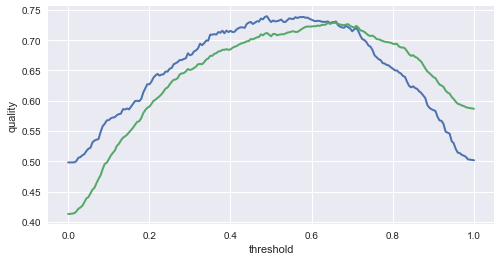

In [87]:
lrclf_params = {"C": 0.04, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
lr_res = cv_fit_predict(LogisticRegression, tt, "b_train", "b_test", lrclf_params, lrfit_params, do_scaling = True)
lr_p, lr_pr = combine_results(lr_res, cv, df.shape[0])
review(df, lr_p, lr_pr, "ibs")

In [88]:
new_lr_p = np.zeros(len(lr_p))
new_lr_p[lr_pr > 0.49] = 1
print accuracy_score(df["ibs"], new_lr_p)

0.711902113459


100%|██████████| 12/12 [00:00<00:00, 32.04it/s]


roc-auc = 0.801010378063
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.710233592881
Качество по людям = 0.732753606518
Наилучшее разбиение происходит при границе 0.46
Качество по сигналам = 0.706340378198
Качество по людям = 0.748336778729


0.7483367787288936

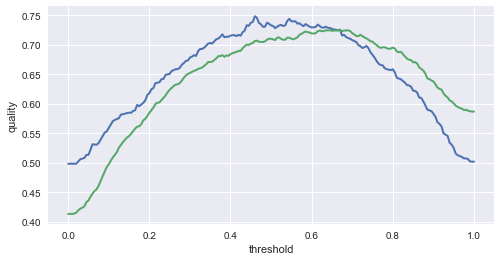

In [101]:
lrclf_params = {"C": 0.0363, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
lr_res = cv_fit_predict(LogisticRegression, tt, "bw_train", "bw_test", lrclf_params, lrfit_params, do_scaling = True)
lr_p_w2v, lr_pr_w2v = combine_results(lr_res, cv, df.shape[0])
review(df, lr_p_w2v, lr_pr_w2v, "ibs")

In [103]:
new_lr_p_w2v = np.zeros(len(lr_p))
new_lr_p_w2v[lr_pr_w2v > 0.46] = 1
print accuracy_score(df["ibs"], new_lr_p_w2v)

0.706340378198


In [66]:
def get_weight(y_train):
    false_w = 1 - len(y_train[y_train==0]) * 1.0 / len(y_train)
    true_w = 1 - len(y_train[y_train==1]) * 1.0 / len(y_train)
    d = {0: false_w, 1: true_w}
    weight = y_train.apply(lambda x: d[x])
    return weight

In [81]:
xgbclf_params = {"objective":"binary:logistic", "max_depth":8, "learning_rate":0.006,
                 "n_estimators": 600, "nthread":-1, "base_score":0.5, "seed":0, "missing":None}
xgbfit_params = {"eval_metric":"auc", "early_stopping_rounds":900, "verbose":False}
xgb_res = cv_fit_predict(xgb.XGBClassifier, tt, "bw_train", "bw_test", xgbclf_params, xgbfit_params, do_scaling = False, xgbfit = True)
xgb_a, xgb_pr = combine_results(xgb_res, cv,  df.shape[0])

100%|██████████| 12/12 [01:31<00:00,  7.53s/it]


roc-auc = 0.755965631837
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.694660734149
Качество по людям = 0.714065980282
Наилучшее разбиение происходит при границе 0.495
Качество по сигналам = 0.693548387097
Качество по людям = 0.715987759746


0.7159877597464894

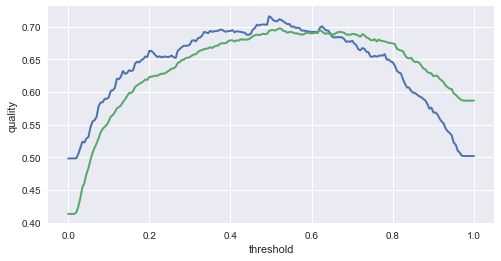

In [82]:
review(df, xgb_a, xgb_pr, "ibs")

In [104]:
new_xgb_a = np.zeros(len(lr_p))
new_xgb_a[xgb_pr > 0.495] = 1
print accuracy_score(df["ibs"], new_xgb_a)

0.693548387097


In [272]:
def save_to_files(tt):
    for index, f in enumerate(tt):
        f["xtest"][["Patient", "texts"]].to_csv("Words_cv/xtest_cv"+str(index))
        f["xtrain"][["Patient", "texts"]].to_csv("Words_cv/xtrain_cv"+str(index))
        pd.DataFrame(f["b_test"]).to_csv("Words_cv/btest_cv"+str(index))
        pd.DataFrame(f["b_train"]).to_csv("Words_cv/btrain_cv"+str(index))
        pd.DataFrame(f["w_test"]).to_csv("Words_cv/wtest_cv"+str(index))
        pd.DataFrame(f["w_train"]).to_csv("Words_cv/wtrain_cv"+str(index))
        pd.DataFrame(f["bw_test"]).to_csv("Words_cv/bwtest_cv"+str(index))
        pd.DataFrame(f["bw_train"]).to_csv("Words_cv/bwtrain_cv"+str(index))

In [273]:
save_to_files(tt)

In [106]:
new_df = pd.DataFrame(data={"ibs":df["ibs"], "ECG_ID":df["ECG_ID"], "WORDS_PR_LR":lr_pr,
                            "WORDS_PR_LR_w2v":lr_pr_w2v, "WORDS_PR_xgb": xgb_pr, 
                            "WORDS_P_LR":lr_p, "WORDS_P_LR_new":new_lr_p,
                            "WORDS_P_LR_w2v":lr_p_w2v, "WORDS_P_LR_new_w2v":new_lr_p_w2v,
                            "WORDS_P_xgb":xgb_a, "WORDS_P_xgb_new":new_xgb_a
                            })

In [109]:
new_df.columns

Index([u'ECG_ID', u'WORDS_PR_LR', u'WORDS_PR_LR_w2v', u'WORDS_PR_xgb',
       u'WORDS_P_LR', u'WORDS_P_LR_new', u'WORDS_P_LR_new_w2v',
       u'WORDS_P_LR_w2v', u'WORDS_P_xgb', u'WORDS_P_xgb_new', u'ibs'],
      dtype='object')

In [115]:
new_df.to_csv("words_results.csv")